In [1]:
import pandas as pd
import numpy as np
import datetime
from IPython import display
from dateutil.parser import parse

from rl4pm_lib.utils_supervised import make_window_features

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import xgboost as xgb

import matplotlib.pyplot as plt

In [2]:
test_df = pd.read_csv('datasets/test_df_nr.csv')
test_df['timestamp'] = test_df['timestamp'].apply(lambda x: parse(x))
test_df['trace_id'] = test_df['trace_id'].apply(lambda x: int(x))

train_df = pd.read_csv('datasets/train_df_nr.csv')
train_df['timestamp'] = train_df['timestamp'].apply(lambda x: parse(x))
train_df['trace+id'] = train_df['trace_id'].apply(lambda x: int(x))

## Proprocessing:
### 1. Make features
For leveraging predictive models the following features are created:
- $t_e$ - time since previous event
- $t_w$ - time since the beginning of week
- $t_t$ - time since the beginning of trace
- one hot encoded labels

### 2. Make window with lags

### 3. Scale it

In [3]:
import rl4pm_lib.preprocessing as preprocessing
# make features
column_feature = {'tt': 0, 'te': 1, 'tw': 2}
prepro = preprocessing.DfPreprocesser()
prepro.fit(train_df)
train_df_pr = prepro.transform(train_df)
test_df_pr = prepro.transform(test_df)

In [4]:
if 'trace+id' in train_df_pr.columns:
    train_df_pr.drop(columns=['trace+id'], inplace=True)

if 'trace+id' in test_df_pr.columns:
    test_df_pr.drop(columns=['trace+id'], inplace=True)

In [5]:
win_len = 2

test_df_pr = test_df_pr.rename(columns={i+1: str(i+1) for i in range(6)})
train_df_pr = train_df_pr.rename(columns={i+1: str(i+1) for i in range(6)})

test_df_pr_win, test_labels, test_tes = make_window_features(train_df_pr, win_len)

train_df_pr_win, train_labels, train_tes = make_window_features(train_df_pr, win_len)

The data above can be just writed to disk so it is fixed

In [6]:
to_write_win_test = test_df_pr_win
to_write_win_test['labels'] = test_labels
to_write_win_test['te_true'] = test_tes

to_write_win_train = train_df_pr_win
to_write_win_train['labels'] = train_labels
to_write_win_train['te_true'] = train_tes

to_write_win_test.to_csv(f'datasets/test_features_win_{win_len}_nr.csv', index=False)
to_write_win_train.to_csv(f'datasets/train_features_win_{win_len}_nr.csv', index=False)

In [7]:
test_df_pr_win = pd.read_csv(f'datasets/test_features_win_{win_len}_nr.csv')
train_df_pr_win = pd.read_csv(f'datasets/train_features_win_{win_len}_nr.csv')

if 'timestamp' in test_df_pr_win:
    test_df_pr_win['timestamp'] = test_df_pr_win['timestamp'].apply(lambda x: parse(x))
if 'timestamp' in train_df_pr_win:
    train_df_pr_win['timestamp'] = train_df_pr_win['timestamp'].apply(lambda x: parse(x))
    
test_df_pr_win.sort_values(by=['timestamp'], inplace=True)
train_df_pr_win.sort_values(by=['timestamp'], inplace=True)

test_labels, test_tes = test_df_pr_win['labels'], test_df_pr_win['te_true']
test_df_pr_win = test_df_pr_win.drop(columns=['labels', 'te_true'])

train_labels, train_tes = train_df_pr_win['labels'], train_df_pr_win['te_true']
train_df_pr_win = train_df_pr_win.drop(columns=['labels', 'te_true'])

In [8]:
activities = []
_d = train_df_pr_win.copy()
for _c in _d.columns:
    if _c.isdigit():
        activities.append(_c)
activities

['1', '2', '3', '4', '5', '6']

In [9]:
if ('timestamp' in train_df_pr_win) and (type(train_df_pr_win['timestamp'].values[0])==str):
    train_df_pr_win['timestamp'] = train_df_pr_win['timestamp'].apply(lambda x: parse(x))
if ('timestamp' in test_df_pr_win) and (type(test_df_pr_win['timestamp'].values[0])==str):
    test_df_pr_win['timestamp'] = test_df_pr_win['timestamp'].apply(lambda x: parse(x))

Also must scale continious (time related features)

In [10]:
train_df_pr_win.shape, train_labels.shape

((9176, 20), (9176,))

In [11]:
from rl4pm_lib.preprocessing import PaperScalerPd as PaperScaler

Let's construct features as moving window

Ok, features and targets are ready, let's do `.fit()`, `.predict())))))`

What methods will I use? Of course all, which were listed [here](https://github.com/lemikhovalex/DA_CV)

## PipeLine

In [12]:
pipe = Pipeline([('scaler', PaperScaler(column_feature)),
                 ('rfc', RandomForestClassifier(n_estimators=30, max_depth=4, random_state=42, n_jobs=-1))
                ])

In [13]:
pipe.fit(train_df_pr_win.drop(columns=['timestamp']), train_labels)

Pipeline(steps=[('scaler',
                 <rl4pm_lib.preprocessing.PaperScalerPd object at 0x0000024CB712A700>),
                ('rfc',
                 RandomForestClassifier(max_depth=4, n_estimators=30, n_jobs=-1,
                                        random_state=42))])

# Classification
## Random Forest Classifier

In [14]:
splitter = TimeSeriesSplit(n_splits=7)
xs = splitter.split(train_df_pr_win, train_labels)

In [57]:
%%time
param_grid = { 
    'rfc__n_estimators': np.linspace(140, 250, num=15, dtype=int),
    'rfc__max_depth' : np.linspace(10, 20, num=10, dtype=int),
}

model_gs = Pipeline([('scaler', PaperScaler(column_feature)),
                     ('rfc', RandomForestClassifier(random_state=42, class_weight='balanced'))
                    ])
CV_rfc = GridSearchCV(estimator=model_gs, param_grid=param_grid, scoring='accuracy',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=3, verbose=1)
CV_rfc.fit(train_df_pr_win, train_labels)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   37.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.5min
[Parallel(n_jobs=3)]: Done 750 out of 750 | elapsed: 11.2min finished


Wall time: 11min 18s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('scaler',
                                        <rl4pm_lib.preprocessing.PaperScalerPd object at 0x00000185A37C79A0>),
                                       ('rfc',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=3,
             param_grid={'rfc__max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 20]),
                         'rfc__n_estimators': array([140, 147, 155, 163, 171, 179, 187, 195, 202, 210, 218, 226, 234,
       242, 250])},
             scoring='accuracy', verbose=1)

In [58]:
CV_rfc.best_params_

{'rfc__max_depth': 18, 'rfc__n_estimators': 226}

In [59]:
rfc_activ_best = CV_rfc.best_estimator_

In [18]:
rfc_activ_best = Pipeline([('scaler', PaperScaler(column_feature)),
                            ('rfc', RandomForestClassifier(random_state=42, 
                                                           max_depth=18,
                                                           n_estimators=218
                                                          ))
                           ])

In [60]:
rfc_activ_best = CV_rfc.best_estimator_

In [61]:
%%time

rfc_activ_best.fit(train_df_pr_win, train_labels)

train_labels_hat = rfc_activ_best.predict(train_df_pr_win)
test_labels_hat = rfc_activ_best.predict(test_df_pr_win)

test_acc_rfc = accuracy_score(test_labels_hat, test_labels)
train_acc_rfc = accuracy_score(train_labels_hat, train_labels)

print(f'Random Forest Classifier, after grid search')
print(f'test  accuracy = {test_acc_rfc: .2f}\ntrain accuracy = {train_acc_rfc: .2f}')
print(f'test  f1 = {f1_score(test_labels, test_labels_hat, average="weighted"): .2f}')
print(f'train f1 = {f1_score(train_labels, train_labels_hat, average="weighted"): .2f}')

Random Forest Classifier, after grid search
test  accuracy =  0.95
train accuracy =  0.95
test  f1 =  0.95
train f1 =  0.95
Wall time: 6.11 s


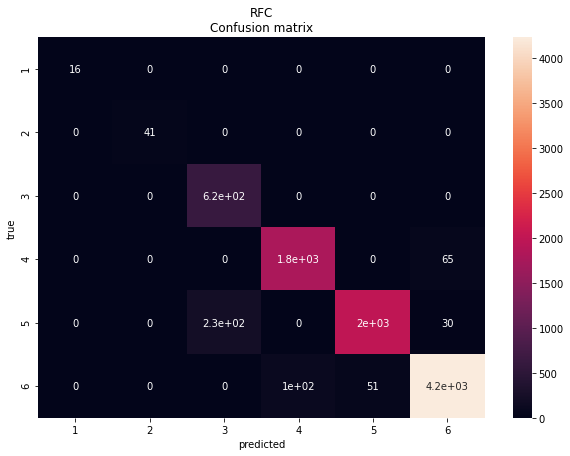

In [62]:

cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('RFC\nConfusion matrix')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

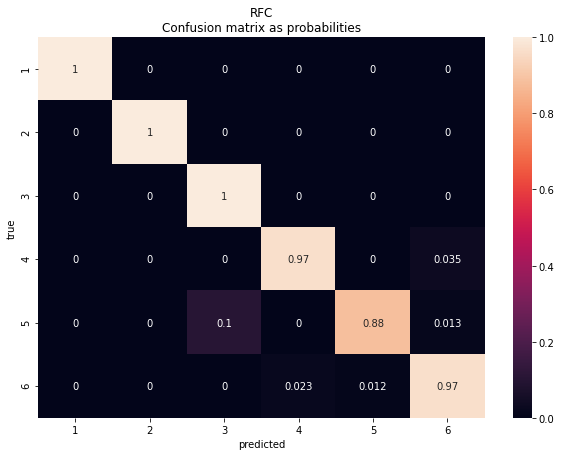

In [63]:

cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm_prob, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('RFC\nConfusion matrix as probabilities')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

Resuls some how are beter then in article on LSTM approach

## RFC not balanced

In [64]:
%%time
param_grid_rfcb = { 
    'rfc__n_estimators': np.linspace(140, 250, num=15, dtype=int),
    'rfc__max_depth' : np.linspace(10, 20, num=10, dtype=int),
}

model_gs_rfcnb = Pipeline([('scaler', PaperScaler(column_feature)),
                           ('rfc', RandomForestClassifier(random_state=42))
                          ])
CV_rfcub = GridSearchCV(estimator=model_gs_rfcnb, param_grid=param_grid, scoring='accuracy',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=3, verbose=1)
CV_rfcub.fit(train_df_pr_win, train_labels)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   35.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.7min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.4min
[Parallel(n_jobs=3)]: Done 750 out of 750 | elapsed: 11.1min finished


Wall time: 11min 13s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('scaler',
                                        <rl4pm_lib.preprocessing.PaperScalerPd object at 0x00000185A6402670>),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=3,
             param_grid={'rfc__max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 20]),
                         'rfc__n_estimators': array([140, 147, 155, 163, 171, 179, 187, 195, 202, 210, 218, 226, 234,
       242, 250])},
             scoring='accuracy', verbose=1)

In [65]:
CV_rfcub.best_params_

{'rfc__max_depth': 10, 'rfc__n_estimators': 171}

In [66]:
rfc_ub_activ_best = CV_rfc.best_estimator_

In [67]:
%%time

rfc_ub_activ_best.fit(train_df_pr_win, train_labels)

train_labels_hat_rfcub = rfc_ub_activ_best.predict(train_df_pr_win)
test_labels_hat_rfcub = rfc_ub_activ_best.predict(test_df_pr_win)

test_acc_rfcub = accuracy_score(test_labels_hat_rfcub, test_labels)
train_acc_rfcub = accuracy_score(train_labels_hat_rfcub, train_labels)

print(f'Random Forest Classifier, after grid search')
print(f'test  accuracy = {test_acc_rfcub: .2f}\ntrain accuracy = {train_acc_rfcub: .2f}')
print(f'test  f1 = {f1_score(test_labels, test_labels_hat_rfcub, average="weighted"): .2f}')
print(f'train f1 = {f1_score(train_labels, train_labels_hat_rfcub, average="weighted"): .2f}')

Random Forest Classifier, after grid search
test  accuracy =  0.95
train accuracy =  0.95
test  f1 =  0.95
train f1 =  0.95
Wall time: 6.45 s


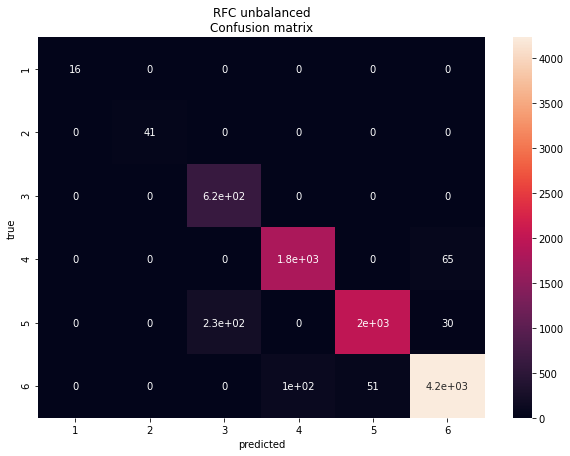

In [68]:

cm = confusion_matrix(test_labels, train_labels_hat_rfcub)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('RFC unbalanced\nConfusion matrix')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

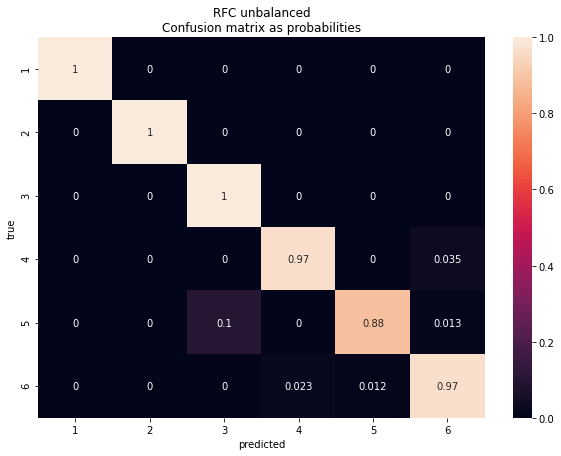

In [69]:

cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm_prob, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('RFC unbalanced\nConfusion matrix as probabilities')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

## Grad Boost

In [70]:
%%time
param = {'objective': 'multi:softprob',  # error evaluation for multiclass training
         'num_class': 6,
         'tree_method': 'gpu_hist',

        }

grid_xgb = {'xgb__max_depth': np.linspace(5, 10, num=5, dtype=int),
            'xgb__n_estimators': np.linspace(3, 10, num=7, dtype=int),
            'xgb__eta': np.linspace(0.001, 0.3, num=15, dtype=float)
           }

model_gs_xgb = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('xgb', xgb.XGBClassifier(**param))
                        ])
CV_xgb = GridSearchCV(estimator=model_gs_xgb, param_grid=grid_xgb, scoring='accuracy',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=3, verbose=1)
CV_xgb.fit(train_df_pr_win, train_labels)

print(CV_xgb.best_score_)
print(CV_xgb.best_params_)

Fitting 5 folds for each of 525 candidates, totalling 2625 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   29.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.0min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  9.0min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed: 14.4min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed: 20.5min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed: 27.7min
[Parallel(n_jobs=3)]: Done 2625 out of 2625 | elapsed: 29.7min finished


0.6856769130150425
{'xgb__eta': 0.27864285714285714, 'xgb__max_depth': 5, 'xgb__n_estimators': 3}
Wall time: 29min 43s


In [71]:
xgb_clf_best = CV_xgb.best_estimator_

In [72]:
xgb_clf_best = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('xgb', xgb.XGBClassifier(objective='multi:softprob',
                                                   num_class=6,
                                                   tree_method='gpu_hist',
                                                   max_depth=8,
                                                   n_estimators=10
                                                  )
                         )]
                       )

In [73]:
xgb_clf_best.fit(train_df_pr_win, train_labels)

train_labels_hat = xgb_clf_best.predict(train_df_pr_win)
test_labels_hat = xgb_clf_best.predict(test_df_pr_win)

test_acc_xgb = accuracy_score(test_labels_hat, test_labels)
train_acc_xgb = accuracy_score(train_labels_hat, train_labels)

print(f'XG boost Classifier')
print(f'test  accuracy = {test_acc_xgb: .2f}\ntrain accuracy = {train_acc_xgb: .2f}')

print(f'test  f1 = {f1_score(test_labels, test_labels_hat, average="weighted"): .2f}')
print(f'train f1 = {f1_score(train_labels, train_labels_hat, average="weighted"): .2f}')

XG boost Classifier
test  accuracy =  0.75
train accuracy =  0.75
test  f1 =  0.74
train f1 =  0.74


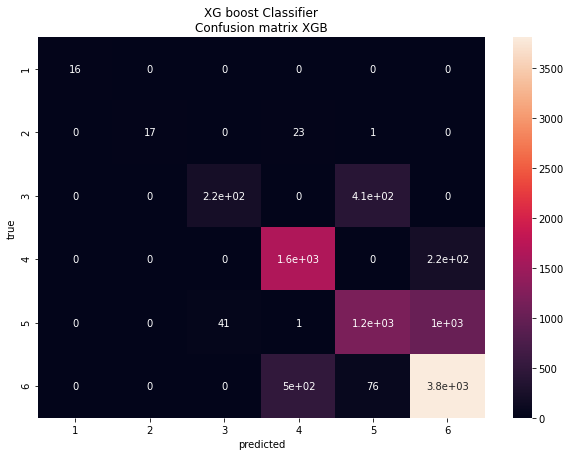

In [74]:
cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('XG boost Classifier\nConfusion matrix XGB')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

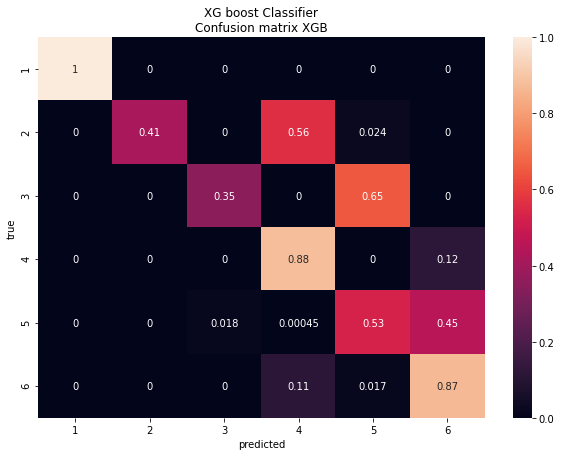

In [75]:
cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm_prob, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('XG boost Classifier\nConfusion matrix XGB')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

## Classification results
Classique approaches povides results, which outperforms result, given in article as baseline, but...

- As been shown in visualization, there are a lot of loops, model that doesnt consern information on all the trail seems to be useless for end time prediction
- Accuracy is what been used for benchmarking in papers. Maybe it is not the best metric? Who knows, nevertheless this is a bench

# Regression

In [76]:
%%time
param_grid_rfr = { 
    'rfr__n_estimators': np.linspace(140, 250, num=15, dtype=int),
    'rfr__max_depth' : np.linspace(10, 20, num=10, dtype=int),
}

model_gs_reg = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('rfr', RandomForestRegressor(random_state=42))
                        ])
CV_rfr = GridSearchCV(estimator=model_gs_reg, param_grid=param_grid_rfr, scoring='neg_mean_absolute_error',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, verbose=1)
CV_rfr.fit(train_df_pr_win, train_tes)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   51.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.9min
[Parallel(n_jobs=3)]: Done 750 out of 750 | elapsed: 17.9min finished


Wall time: 17min 59s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('scaler',
                                        <rl4pm_lib.preprocessing.PaperScalerPd object at 0x00000185AAFC5C40>),
                                       ('rfr',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=3,
             param_grid={'rfr__max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 20]),
                         'rfr__n_estimators': array([140, 147, 155, 163, 171, 179, 187, 195, 202, 210, 218, 226, 234,
       242, 250])},
             scoring='neg_mean_absolute_error', verbose=1)

In [77]:
CV_rfr.best_params_

{'rfr__max_depth': 10, 'rfr__n_estimators': 140}

In [78]:
rfr =  Pipeline([('scaler', PaperScaler(column_feature)),
                 ('rfr', RandomForestRegressor(random_state=42,
                                               n_estimators=163,
                                               max_depth=10
                                              ))
                        ])

In [79]:
rfr = CV_rfr.best_estimator_
rfr.fit(train_df_pr_win, train_tes)
train_tes_hat_rfr = rfr.predict(train_df_pr_win)
test_tes_hat_rfr = rfr.predict(test_df_pr_win)

test_mae_xgb = MAE(test_tes_hat_rfr, test_tes) / 3600. / 24
train_mae_xgb = MAE(train_tes_hat_rfr, train_tes) / 3600. / 24

print(f'Random Forest Regression')
print(f'MAE  accuracy = {test_mae_xgb: .2f}, days\ntrain MAE = {test_mae_xgb: .2f}, days')

Random Forest Regression
MAE  accuracy =  4.05, days
train MAE =  4.05, days


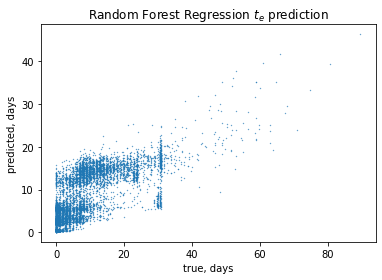

In [80]:
plt.scatter(test_tes / 3600. / 24, test_tes_hat_rfr / 3600. / 24, s=0.1)
plt.title('Random Forest Regression $t_e$ prediction')
plt.xlabel('true, days')
plt.ylabel('predicted, days')
plt.show()

[]

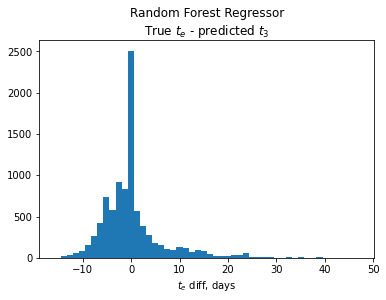

In [81]:
plt.hist((test_tes - test_tes_hat_rfr) / 3600. / 24, bins=50)
plt.xlabel('$t_e$ diff, days')
plt.title('Random Forest Regressor\nTrue $t_e$ - predicted $t_3$')
plt.plot()

## Dull

In [33]:
train_tes.mean() / 3600. / 24, train_tes.median() / 3600. / 24

(7.059265732466337, 2.9658680555555557)

In [31]:
te_dull = train_tes.mean()
test_dull = te_dull * np.ones(test_tes.shape)
train_dull = te_dull * np.ones(train_tes.shape)

test_mae_dull = MAE(test_dull, test_tes) / 3600. / 24
train_mae_dull = MAE(train_dull, train_tes) / 3600. / 24

print(f'Random Forest Regression')
print(f'MAE  accuracy = {test_mae_dull: .2f}, days\ntrain MAE = {test_mae_dull: .2f}, days')

Random Forest Regression
MAE  accuracy =  7.06, days
train MAE =  7.06, days


Again better then papers)

In [18]:
param = {'tree_method': 'gpu_hist'
        }

grid_xgbr = {'xgbr__max_depth': np.linspace(5, 10, num=5, dtype=int),
            'xgbr__n_estimators': np.linspace(3, 10, num=5, dtype=int),
            'xgbr__eta': np.linspace(0.001, 0.3, num=5, dtype=float)
           }

model_gs_xgbr = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('xgbr', xgb.XGBClassifier(**param))
                        ])
CV_xgbr = GridSearchCV(estimator=model_gs_xgbr, param_grid=grid_xgbr, scoring='neg_mean_absolute_error',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=1, verbose=1)
CV_xgbr.fit(train_df_pr_win, train_tes)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed: 451.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('scaler',
                                        <rl4pm_lib.preprocessing.PaperScalerPd object at 0x0000024CBA6D0760>),
                                       ('xgbr',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constra...
                                                      random_state=None,
                                               

In [19]:
model_gs_xgbr = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('xgbr', xgb.XGBClassifier(max_depth=10,
                                                    n_estimators=7,
                                                    eta=0.1
                                                   ))
                        ])

In [24]:
CV_xgbr.best_params_

{'xgbr__eta': 0.22525, 'xgbr__max_depth': 5, 'xgbr__n_estimators': 6}

In [ ]:
xgbr = CV_xgbr.best_estimator_
xgbr.fit(train_df_pr_win, train_tes)
train_tes_hat_xgbr = xgbr.predict(train_df_pr_win)
test_tes_hat_xgbr = xgbr.predict(test_df_pr_win)

test_mae_xgbr = MAE(test_tes_hat_xgbr, test_tes) / 3600. / 24
train_mae_xgbr = MAE(train_tes_hat_xgbr, train_tes) / 3600. / 24

print(f'Random Forest Regression')
print(f'MAE  accuracy = {test_mae_xgbr: .2f}, days\ntrain MAE = {test_mae_xgbr: .2f}, days')

In [27]:
print(f'XGB Regressor')
print(f'MAE       = {test_mae_xgbr: .2f}, days\ntrain MAE = {test_mae_xgbr: .2f}, days')

XGB Regressor
MAE       =  7.06, days
train MAE =  7.06, days


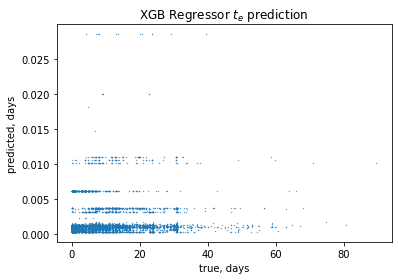

In [22]:
plt.scatter(test_tes / 3600. / 24, test_tes_hat_xgbr / 3600. / 24, s=0.1)
plt.title('XGB Regressor $t_e$ prediction')
plt.xlabel('true, days')
plt.ylabel('predicted, days')
plt.show()

[]

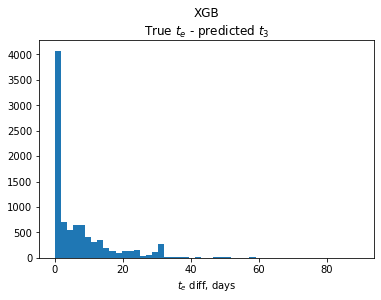

In [23]:
plt.hist((test_tes - test_tes_hat_xgbr) / 3600. / 24, bins=50)
plt.xlabel('$t_e$ diff, days')
plt.title('XGB\nTrue $t_e$ - predicted $t_3$')
plt.plot()

XGB is not that cool

## Ridge

In [19]:
grid_ridge = {'ridge__alpha': np.linspace(1., 30., num=100, dtype=float)}

model_gs_ridge = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('ridge', Ridge())
                        ])
CV_ridge = GridSearchCV(estimator=model_gs_ridge, param_grid=grid_ridge, scoring='neg_mean_absolute_error',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=3, verbose=1)
CV_ridge.fit(train_df_pr_win, train_tes)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  4.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('scaler',
                                        <rl4pm_lib.preprocessing.PaperScalerPd object at 0x000002A5CAE82940>),
                                       ('ridge', Ridge())]),
             n_jobs=3,
             param_grid={'ridge__alpha': array([ 1.        ,  1.29292929,  1.58585859,  1.87878788,  2.17171717,
        2.46464646,  2.75757576,  3.05050505,  3.34343434,  3.63636364,
        3.92929293,  4.22222...
       21.50505051, 21.7979798 , 22.09090909, 22.38383838, 22.67676768,
       22.96969697, 23.26262626, 23.55555556, 23.84848485, 24.14141414,
       24.43434343, 24.72727273, 25.02020202, 25.31313131, 25.60606061,
       25.8989899 , 26.19191919, 26.48484848, 26.77777778, 27.07070707,
       27.36363636, 27.65656566, 27.94949495, 28.24242424, 28.53535354,
       28.82828283, 29.12121212, 29.41414141, 29.70707071, 30.        ])},
             scoring='neg_mean_absolu

In [20]:
CV_ridge.best_params_

{'ridge__alpha': 30.0}

In [21]:
ridge = CV_ridge.best_estimator_
ridge.fit(train_df_pr_win, train_tes)
train_tes_hat_ridge = ridge.predict(train_df_pr_win)
test_tes_hat_ridge = ridge.predict(test_df_pr_win)

test_mae_ridge = MAE(test_tes_hat_ridge, test_tes) / 3600. / 24
train_mae_ridge = MAE(train_tes_hat_ridge, train_tes) / 3600. / 24

print(f'Random Forest Regression')
print(f'MAE  accuracy = {test_mae_ridge: .2f}, days\ntrain MAE = {test_mae_ridge: .2f}, days')

Random Forest Regression
MAE  accuracy =  4.98, days
train MAE =  4.98, days


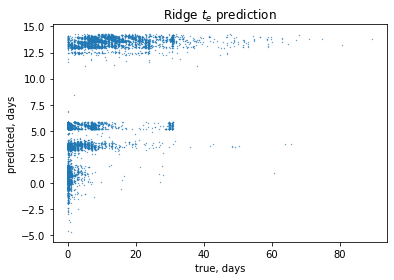

In [22]:
plt.scatter(test_tes / 3600. / 24, test_tes_hat_ridge / 3600. / 24, s=0.1)
plt.title('Ridge $t_e$ prediction')
plt.xlabel('true, days')
plt.ylabel('predicted, days')
plt.show()

[]

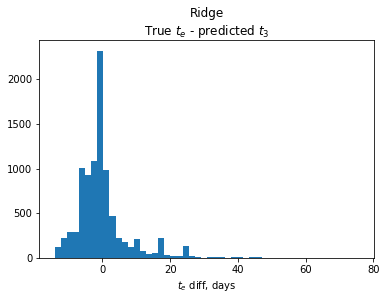

In [23]:
plt.hist((test_tes - test_tes_hat_ridge) / 3600. / 24, bins=50)
plt.xlabel('$t_e$ diff, days')
plt.title('Ridge\nTrue $t_e$ - predicted $t_3$')
plt.plot()